# Building a RNN on SMILES data

In [23]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [24]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import pickle


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Flatten, Dropout, MaxPooling2D, GRU, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

%run ../assets/accuracy_loss_plots.py # function to plot accuracy and loss
%run ../assets/confusion_matrix.py # function to plot confusion matrix
%run ../assets/smiles_tokenizer.py # function to tokenize SMILES
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')

## Read in data

In [25]:
df = pd.read_csv("../data/CID_properties_nr.csv")

In [26]:
# lowercase column names
df.columns = df.columns.str.lower()

In [27]:
# remove extra classes
index_names = df[(df["drug_class"] == "antineoplastic") | (df["drug_class"] == "cns") | (df["drug_class"] == "cardio")].index

df = df.loc[index_names]

In [28]:
df["drug_class"].value_counts()

antineoplastic    1174
cns               1141
cardio             787
Name: drug_class, dtype: int64

## Set up X and y variables

In [29]:
# Make my drug class variable categorical

In [30]:
classes_dict = {
    "antineoplastic": 0,
    "cardio": 1,
    "cns": 2,}

In [31]:
# map drug classes to numerical
df['drug_class'] = df['drug_class'].map(classes_dict)
df.head()

,cid,hbondacceptorcount,hbonddonorcount,isomericsmiles,molecularweight,xlogp,drug_class,desalted_smiles
1,134694070,9,6,C1CN=C(N1)NC2=C(C3=NC=CN=C3C=C2)Br.[C@@H](C(C(...,442.226,NaN,1,Brc1c(NC2=NCCN2)ccc2nccnc12
3,4660557,1,1,C1C2CC3CC1CC(C2)C3NC4=CC=C(C=C4)Br,306.247,5.0,2,Brc1ccc(NC2C3CC4CC(C3)CC2C4)cc1
4,122175,2,2,CC(CCC(C#C)N)N,126.203,-0.4,0,C#CC(N)CCC(C)N
5,5281077,1,1,CCC(/C=C/Cl)(C#C)O,144.598,1.5,2,C#CC(O)(/C=C/Cl)CC
12,92913,1,1,CC(CC1=CC=CC=C1)N(C)CC#C.Cl,223.744,NaN,2,C#CCN(C)C(C)Cc1ccccc1


In [32]:
# check that the values are still the same
df["drug_class"].value_counts()

0    1174
2    1141
1     787
Name: drug_class, dtype: int64

In [33]:
# set up my X and y variables
X = df["desalted_smiles"]
y = df["drug_class"]

In [34]:
# Split my train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    stratify = y, random_state = 42)

## Check for two letter elements

In [36]:
# List of two letter elements
two_letter_elements = ['Li','Na','Al','Si','Cl','Sc','Zn','As','Se','Br','Sn','Te','Cn']

In [37]:
# Custom function to check for two letter elements in my list of smiles
def check_two_letters(smile):
    elements = []
    for element in two_letter_elements:
        if df["desalted_smiles"].str.contains(element).sum() > 0:
            sum = df["desalted_smiles"].str.contains(element).sum()
            elements.append(element)
            print(f"{element} found in {sum} rows")
    return elements

In [38]:
# Check for which two letter elements are included in my smiles
two_letters = check_two_letters(df["desalted_smiles"])

Al found in 1 rows
Cl found in 377 rows
Sc found in 63 rows
As found in 2 rows
Se found in 4 rows
Br found in 42 rows
Cn found in 59 rows


In [39]:
two_letters

['Al', 'Cl', 'Sc', 'As', 'Se', 'Br', 'Cn']

## Preprocess Text

In [40]:
# set up tokenizer
tokenizer = Tokenizer(char_level=True, lower = False , oov_token="Cl")
tokenizer.fit_on_texts(df["desalted_smiles"])
sequence_of_int = tokenizer.texts_to_sequences(df["desalted_smiles"])

In [41]:
# Tokenize text
X_train_tk = tokenizer.texts_to_matrix(X_train, mode='count' )
X_test_tk = tokenizer.texts_to_matrix(X_test, mode='count' )

In [42]:
# This is how you can recover the word index that was computed
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 51 unique tokens.


In [44]:
# Checking format of np array
X_train_tk[0]

array([ 0.,  0., 82.,  0., 44., 44., 32., 27.,  2., 17., 17., 25., 17.,
       21.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [46]:
# tokenizer keeps the special characters by default! 
# This is useful for me since the special characters have significance in SMILES
word_index

{'Cl': 1,
 'C': 2,
 'c': 3,
 '(': 4,
 ')': 5,
 'O': 6,
 '@': 7,
 '1': 8,
 '[': 9,
 ']': 10,
 '=': 11,
 'H': 12,
 'N': 13,
 '2': 14,
 '3': 15,
 'n': 16,
 '4': 17,
 '/': 18,
 '5': 19,
 '-': 20,
 'S': 21,
 'l': 22,
 'F': 23,
 '+': 24,
 '6': 25,
 '\\': 26,
 '.': 27,
 'P': 28,
 '#': 29,
 's': 30,
 'o': 31,
 '7': 32,
 'B': 33,
 'r': 34,
 '8': 35,
 't': 36,
 'I': 37,
 '9': 38,
 'e': 39,
 'A': 40,
 'G': 41,
 'm': 42,
 'M': 43,
 '%': 44,
 '0': 45,
 'i': 46,
 'T': 47,
 'u': 48,
 'a': 49,
 'b': 50,
 'X': 51}

# Build model w/ Regularization

In [47]:
model = Sequential([
    Embedding(500,64, input_length = 52),
    SimpleRNN(100),
    Dense(64, activation = "relu"),
    Dropout(0.5),
    Dense(32, activation = "relu"),
    Dropout(0.5),
    Dense(3, activation = "softmax")
])

model.compile(optimizer = "adam", loss =  "sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [48]:
# stop this model when it gets worse
es = EarlyStopping(
    monitor = "val_loss",
    patience = 5, # wait 5 epochs before we really think this model is getting worse
    min_delta = 0 # delta is the difference of validation loss from epoch to epoch. Any increase in validation loss would be considered an increase
)

In [49]:
np.random.RandomState(2020)
history = model.fit(X_train_tk, y_train,
                   epochs = 100,
                   batch_size = 128, 
                   validation_data = (X_test_tk, y_test),
                   verbose = 2,
                   callbacks = [es]
)

Train on 2481 samples, validate on 621 samples
Epoch 1/100
2481/2481 - 2s - loss: 1.0881 - accuracy: 0.3906 - val_loss: 1.0627 - val_accuracy: 0.4573
Epoch 2/100
2481/2481 - 0s - loss: 1.0504 - accuracy: 0.4563 - val_loss: 1.0264 - val_accuracy: 0.4831
Epoch 3/100
2481/2481 - 0s - loss: 1.0423 - accuracy: 0.4716 - val_loss: 1.0381 - val_accuracy: 0.4911
Epoch 4/100
2481/2481 - 0s - loss: 1.0205 - accuracy: 0.4958 - val_loss: 0.9920 - val_accuracy: 0.5233
Epoch 5/100
2481/2481 - 0s - loss: 0.9862 - accuracy: 0.5296 - val_loss: 0.9865 - val_accuracy: 0.5201
Epoch 6/100
2481/2481 - 0s - loss: 0.9828 - accuracy: 0.5381 - val_loss: 1.0088 - val_accuracy: 0.5121
Epoch 7/100
2481/2481 - 0s - loss: 0.9938 - accuracy: 0.5183 - val_loss: 0.9761 - val_accuracy: 0.5137
Epoch 8/100
2481/2481 - 0s - loss: 0.9574 - accuracy: 0.5357 - val_loss: 0.9778 - val_accuracy: 0.5072
Epoch 9/100
2481/2481 - 0s - loss: 0.9554 - accuracy: 0.5449 - val_loss: 0.9772 - val_accuracy: 0.5298
Epoch 10/100
2481/2481 - 0

### Evaluate Model

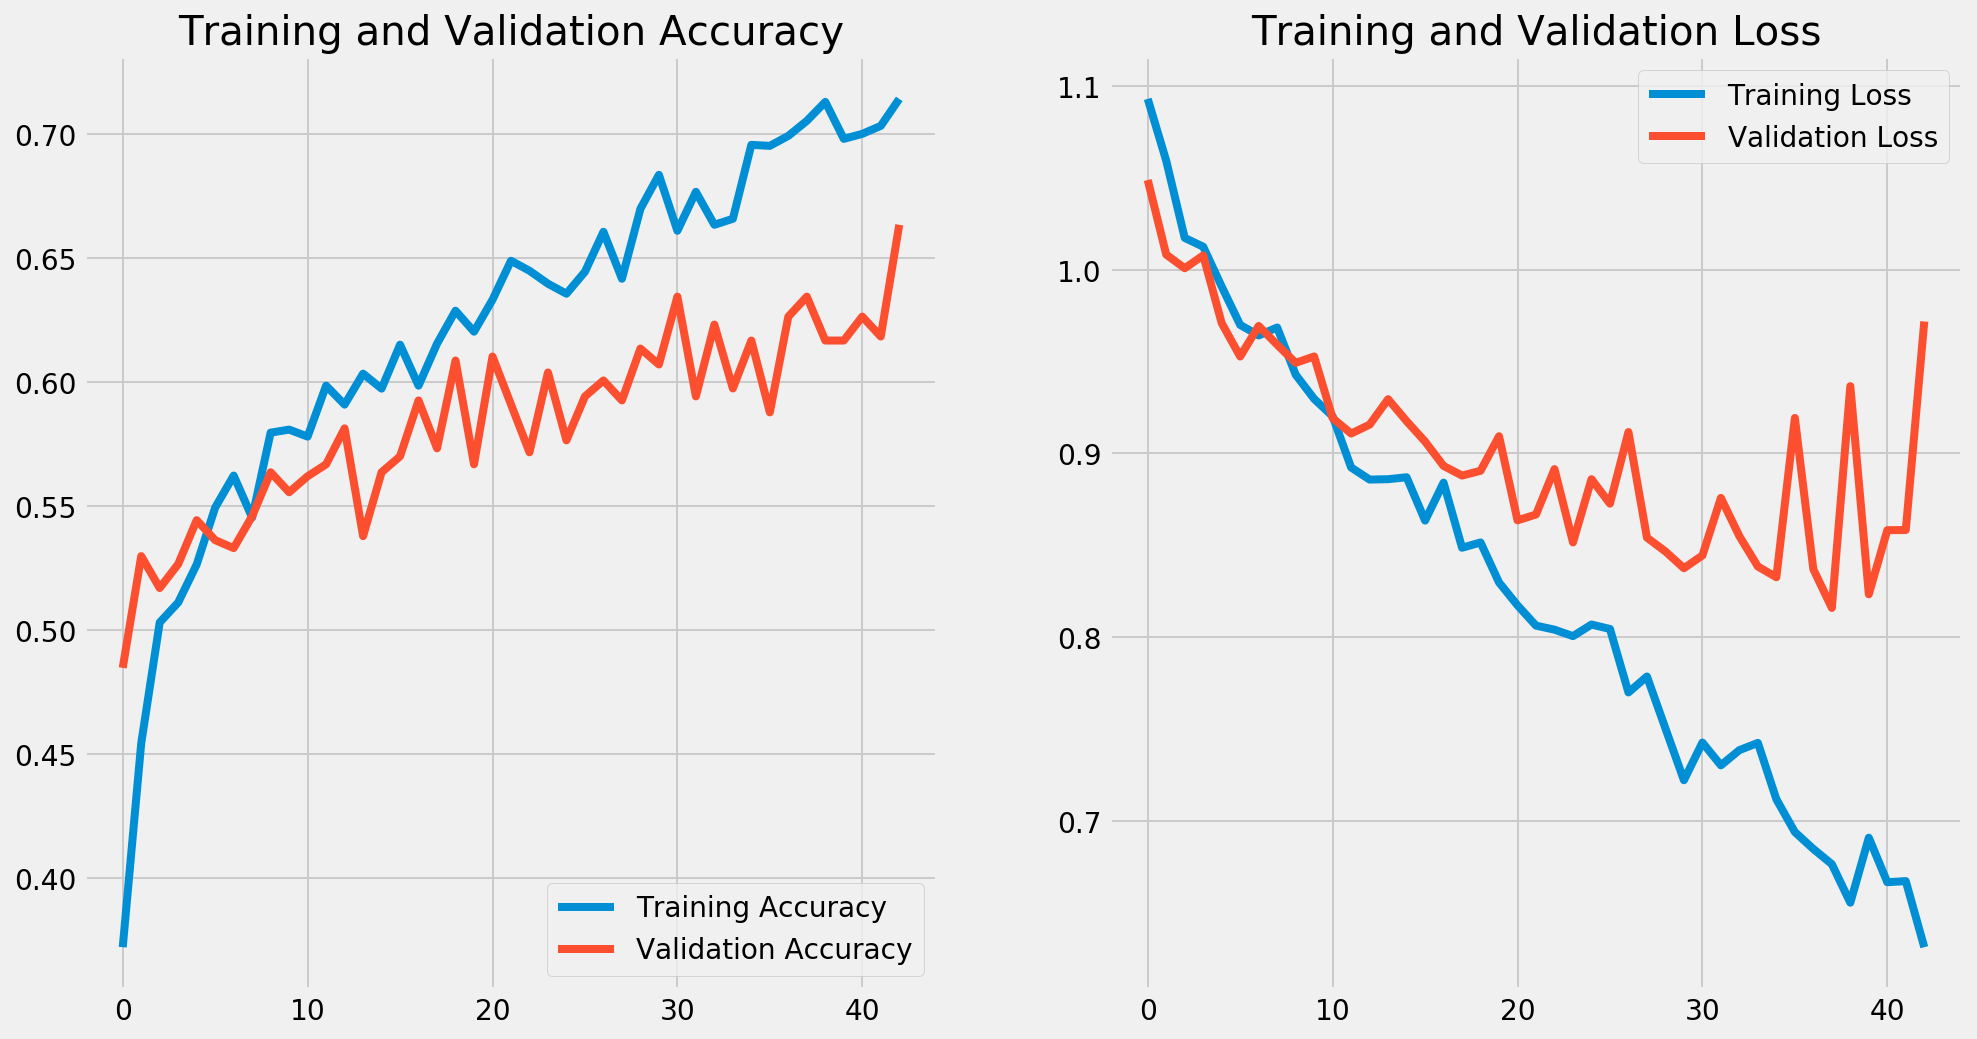

In [181]:
# plot accuracy and loss for model
plot_accuracy_loss(history, epochs = 43);

## Generate predictions

In [52]:
# make predictions on test set
preds = model.predict_classes(X_test_tk)

In [53]:
val_acc = round(history.history['val_accuracy'][-1], 2)

Confusion matrix, without normalization
[[166  30  39]
 [ 50  60  48]
 [ 48  32 148]]


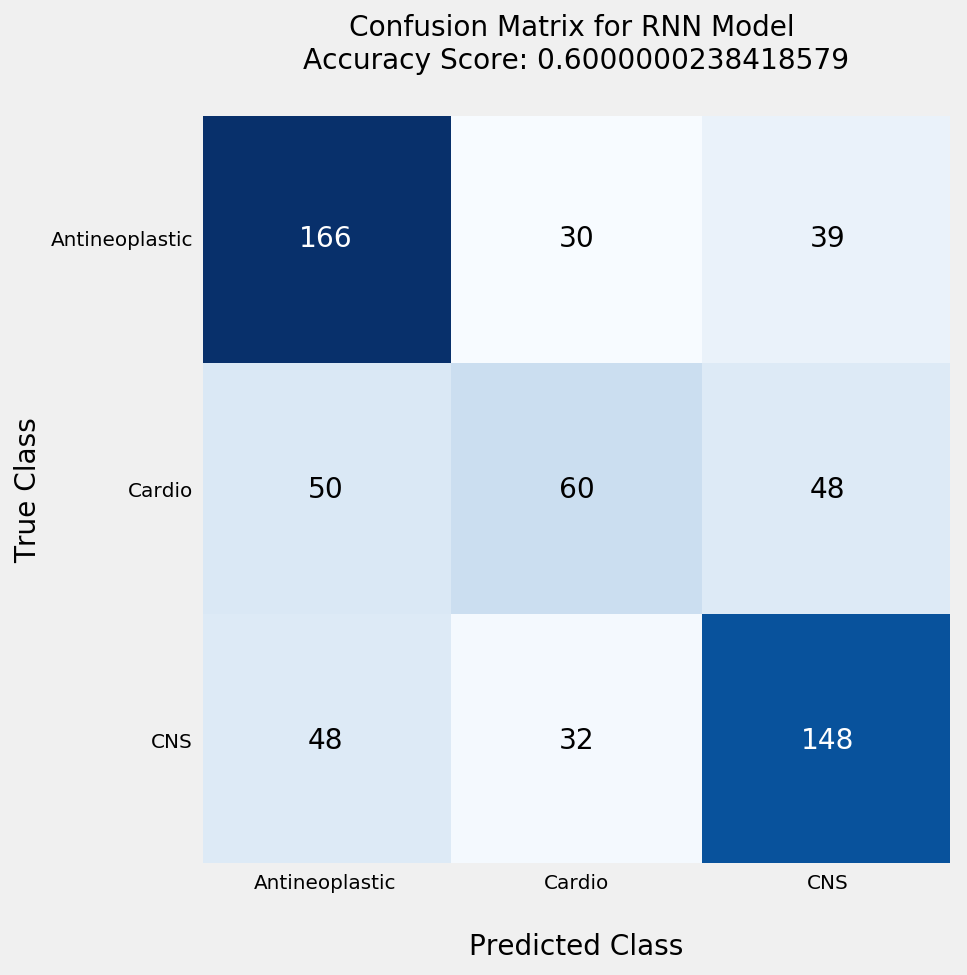

In [54]:
# Look at confusion matrix
cnf_matrix = confusion_matrix(y_test, preds,labels=[0, 1, 2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize = (7, 7))
plot_confusion_matrix(cnf_matrix, classes=['Antineoplastic','Cardio',  'CNS'],
                      title=f'Confusion Matrix for RNN Model \nAccuracy Score: {val_acc}\n' )
plt.savefig("../plots/confusion_matrix_rnn.png", dpi = 150);

In [ ]:
model = Sequential([
    Embedding(500,64, input_length = 52),
    SimpleRNN(100),
    Dense(64, activation = "relu"),
    Dropout(0.5),
    Dense(32, activation = "relu"),
    Dropout(0.5),
    Dense(3, activation = "softmax")
])

model.compile(optimizer = "adam", loss =  "sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [48]:
model = Sequential()
model.add(Embedding(500, 64, input_length = 52))
model.add(LSTM(512))
Dropout(0.5)
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['acc'])

history = model.fit(X_train_tk, y_train,
                   epochs = 20,
                   batch_size = 128, 
                   validation_data = (X_test_tk, y_test),
                   verbose = 2,)

Train on 2481 samples, validate on 621 samples
Epoch 1/20
2481/2481 - 31s - loss: 1.0892 - acc: 0.3583 - val_loss: 1.0855 - val_acc: 0.3784
Epoch 2/20
2481/2481 - 24s - loss: 1.0858 - acc: 0.3680 - val_loss: 1.0841 - val_acc: 0.3784
Epoch 3/20
2481/2481 - 21s - loss: 1.0848 - acc: 0.3531 - val_loss: 1.0839 - val_acc: 0.3784
Epoch 4/20
2481/2481 - 19s - loss: 1.0840 - acc: 0.3785 - val_loss: 1.0839 - val_acc: 0.3784
Epoch 5/20
2481/2481 - 24s - loss: 1.0845 - acc: 0.3692 - val_loss: 1.0841 - val_acc: 0.3784
Epoch 6/20
2481/2481 - 22s - loss: 1.0841 - acc: 0.3785 - val_loss: 1.0850 - val_acc: 0.3784
Epoch 7/20
2481/2481 - 21s - loss: 1.0855 - acc: 0.3668 - val_loss: 1.0839 - val_acc: 0.3784
Epoch 8/20
2481/2481 - 15s - loss: 1.0839 - acc: 0.3769 - val_loss: 1.0843 - val_acc: 0.3671
Epoch 9/20
2481/2481 - 16s - loss: 1.0839 - acc: 0.3696 - val_loss: 1.0838 - val_acc: 0.3784
Epoch 10/20
2481/2481 - 29s - loss: 1.0839 - acc: 0.3785 - val_loss: 1.0841 - val_acc: 0.3784
Epoch 11/20
2481/2481 

### Save Model

In [188]:
#save model
model3.save("../assets/model_rnn.h5")